In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import katdal
import time

### Utility functions for getting MeerKAT channel number to frequency mappings

In [2]:
def freq2chan(frequency, bandwidth, n_chans):
    channel_nr = round(float(frequency)/float(bandwidth)*n_chans)%n_chans
    return int(channel_nr)

def chan2bbfreq(channel_nr, bandwidth, n_chans):
    frequency = round(float(channel_nr)/float(n_chans)*float(bandwidth))%bandwidth
    return frequency

def chan2freq(channel_nr, bandwidth, channel_freqs):
    frequency = chan2bbfreq(channel_nr, bandwidth, len(channel_freqs))
    c_width = np.mean(np.diff(channel_freqs))
    return channel_freqs[0] + frequency - c_width/2.

In [3]:
# 64A small example data set
filename='/home/jupyter/example-data/1548939342/1548939342/1548939342_sdp_l0.full.rdb'

In [5]:
data = katdal.open(filename, applycal=['K','B','G'])
print '(dumps x channels x baselines) = {}'.format(data.shape)
print data.vis.dataset
print data.vis.dataset.chunksize

(dumps x channels x baselines) = (27, 1024, 5100)
dask.array<apply_vis_correction, shape=(27, 1024, 5100), dtype=complex64, chunksize=(1, 128, 5100)>
(1, 128, 5100)


For reference, the frequency band $1326.21\,MHz$ to $1368.01\,MHz$ is clean for MeerKAT and a good location for initial inspection and calculation.

In [6]:
# subset of channels that are known to be relative RFI free (close and around 1.4GHz)
f_low = 1326214844.0
f_high = 1368011719.0
# get MeerKAT channels for frequency range
bandwidth = data.channel_width*len(data.channels)
n_chans = len(data.channels)
c_low = freq2chan(f_low, bandwidth, n_chans)
c_high = freq2chan(f_high, bandwidth, n_chans)

print('Frequency range {:.3f}-{:.3f} MHz maps to channels {}-{}'.format(
    f_low/1e6, f_high/1e6, c_low, c_high))
print('{} channels over bandpass, maps to {:.3f}-{:.3f} MHz'.format(
    n_chans,
    chan2freq(c_low, bandwidth, data.channel_freqs)/1e6,
    chan2freq(c_high, bandwidth, data.channel_freqs)/1e6))

Frequency range 1326.215-1368.012 MHz maps to channels 563-613
1024 channels over bandpass, maps to 1326.215-1368.012 MHz


It is best to use as big a chunk of data to process as possible. Breaking data over time (dumps) are more efficient. Adressing data per antenna is very inefficient. Baseline products are the last dimension and thus data over all baselines need to be unpacked everytime to extract per antenna data.

In [7]:
# select target of interest
target = 'PKS 1934-63'
# subset of channels that are known to be relative RFI free (around 1.4GHz)
chan_slice = slice(c_low, c_high)

In [8]:
stime = time.time()
data.select()
data.select(targets=target, scans='track')
print 'time to select target = {} s'.format(time.time() - stime)
time_idx = range(data.shape[0])

time to select target = 0.00574707984924 s


Plot passband of auto correlations

0 H
time to calculate passband means = 1.60804796219 s
1 V


/usr/lib/python2.7/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


time to calculate passband means = 1.03170108795 s


Text(0.5,0,'channels [#]')

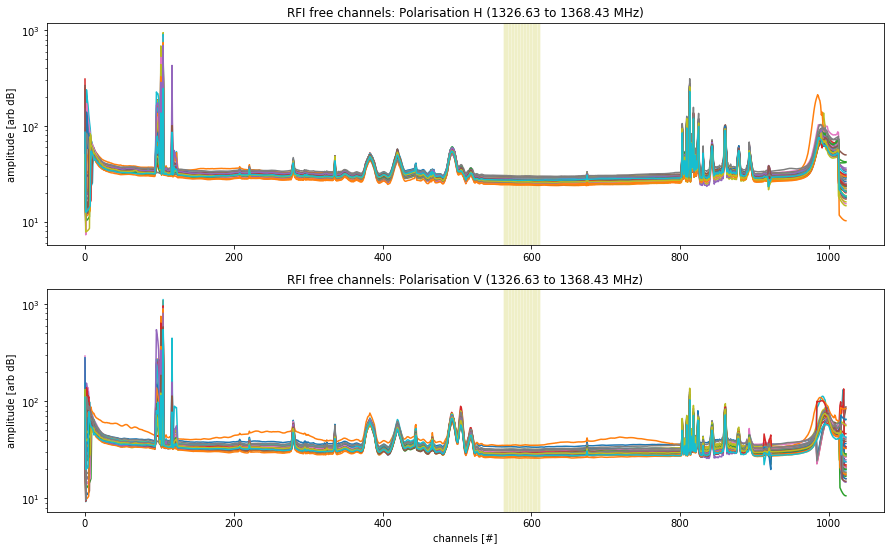

In [9]:
plt.figure(figsize=[15,9])
for idx, pol in enumerate(['H', 'V']):
    print idx, pol
    
    stime = time.time()
    data.select(pol=pol, corrprods='auto')
    bandpass = data.vis.dataset.mean(axis=0).compute()
    data.select(reset='B')
    print 'time to calculate passband means = {} s'.format(time.time() - stime)
    
    plt.subplot(2, 1, idx+1)
    for chan in data.channels[chan_slice]:
        plt.axvline(x=data.channels[chan], color='y', alpha=0.1)
    plt.semilogy(data.channels, bandpass)
    plt.axis('tight')
    plt.title('RFI free channels: Polarisation %s (%.2f to %.2f MHz)' % \
             (pol, data.channel_freqs[chan_slice.start]/1e6, data.channel_freqs[chan_slice.stop]/1e6))
    plt.ylabel('amplitude [arb dB]')
plt.xlabel('channels [#]')

Use flags to remove channels known to have RFI

Note: pre-flagging is generally only good to use for continuum imaging and not for spectral lines, since it will flag out the science lines.   
The most common bad data are probably malfunctioning antennas and channels corrupted by RFI.

0 H
time to flag and calculate passband means = 1.84502601624 s
1 V
time to flag and calculate passband means = 1.54965591431 s


Text(0.5,0,'channels [#]')

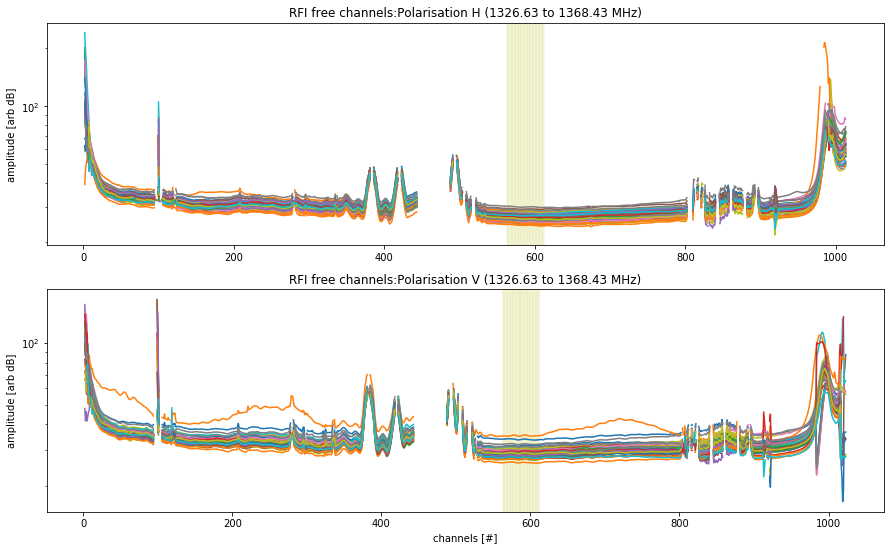

In [10]:
plt.figure(figsize=[15,9])
for idx, pol in enumerate(['H', 'V']):
    print idx, pol
    
    stime = time.time()
    data.select(pol=pol, corrprods='auto')
    vis, flags = np.array(katdal.lazy_indexer.DaskLazyIndexer.get([data.vis, data.flags], time_idx)).squeeze()
    visibilities=np.abs(vis[:])
    dataflags = np.array(flags, dtype=bool)
    visibilities[dataflags]=np.nan    
    bandpass = np.mean(visibilities, axis=0)
    data.select(reset='B')
    print 'time to flag and calculate passband means = {} s'.format(time.time() - stime)
    
    plt.subplot(2,1,idx+1)
    for chan in data.channels[chan_slice]:
        plt.axvline(x=data.channels[chan], color='y', alpha=0.1)
    plt.semilogy(data.channels, bandpass)
    plt.axis('tight')
    plt.title('RFI free channels:Polarisation %s (%.2f to %.2f MHz)' % \
             (pol, data.channel_freqs[chan_slice.start]/1e6, data.channel_freqs[chan_slice.stop]/1e6))
    plt.ylabel('amplitude [arb dB]')
plt.xlabel('channels [#]')

### Inspect antennas
For point-like sources the uncalibrated visibility amplitude on all baselines should be approximately the same, and the uncalibrated visibility phases should be fairly stable, although not necessarily close to 0 deg.   
Thus plot amplitude for all baseline together, investigate any outlier baselines to identify possible bad antenna data.

0 H


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


time to calculate amp and phase = 2.82010388374 s
1 V
time to calculate amp and phase = 2.77116012573 s


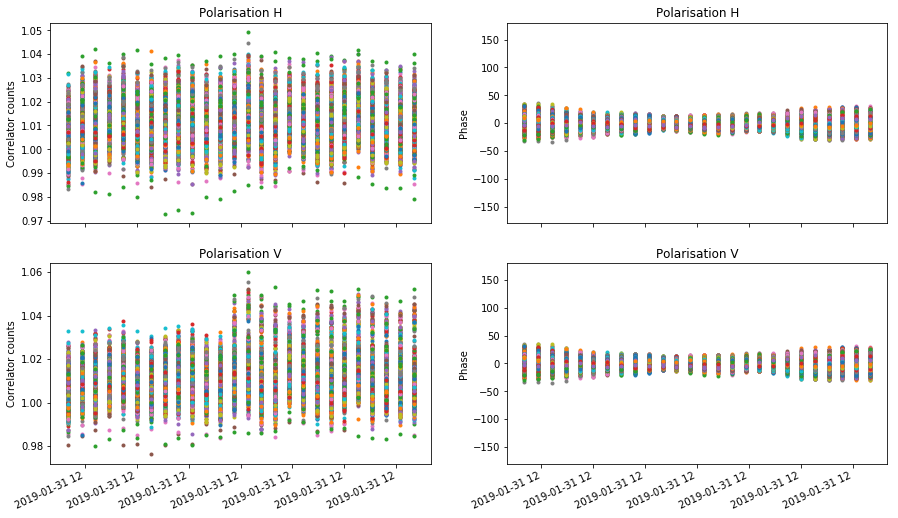

In [11]:
import datetime
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 2, figsize=[15,9], sharex=True)
date_fmt = "%Y-%m-%d %H"
date_formatter = mdates.DateFormatter(date_fmt)

for idx, pol in enumerate(['H', 'V']):
    print idx, pol
    
    stime = time.time()    
    data.select(pol=pol, corrprods='cross')
    vis, flags = np.array(katdal.lazy_indexer.DaskLazyIndexer.get([data.vis, data.flags], time_idx)).squeeze()
    visibilities=vis[:]
    dataflags = np.array(flags, dtype=bool)
    visibilities[dataflags]=np.nan    
    bandpass = np.mean(visibilities, axis=0)
    timeseries = np.nanmean(np.abs(visibilities), axis=1)
    mymean= np.mean(timeseries, axis=0)
    phase = np.nanmean(np.angle(visibilities, deg=True), axis=1)
    data.select(reset='B')
    print 'time to calculate amp and phase = {} s'.format(time.time() - stime)

    datetimes = [datetime.datetime.fromtimestamp(unix_timestamp) for unix_timestamp in data.timestamps]
    axes[idx, 0].plot_date(datetimes, timeseries, '.')
    axes[idx, 0].set_ylabel('Correlator counts')
    axes[idx, 0].set_title('Polarisation %s' % pol)
    axes[idx, 1].plot_date(datetimes, phase, '.')
    axes[idx, 1].set_ylabel('Phase')
    axes[idx, 1].set_title('Polarisation %s' % pol)
    axes[idx, 1].set_ylim([-180, 180])
    axes[1,1].xaxis.set_major_formatter(date_formatter)
fig.autofmt_xdate(rotation=25)

0 H


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


time to calculate phases = 2.40325903893 s
1 V
time to calculate phases = 2.37578296661 s


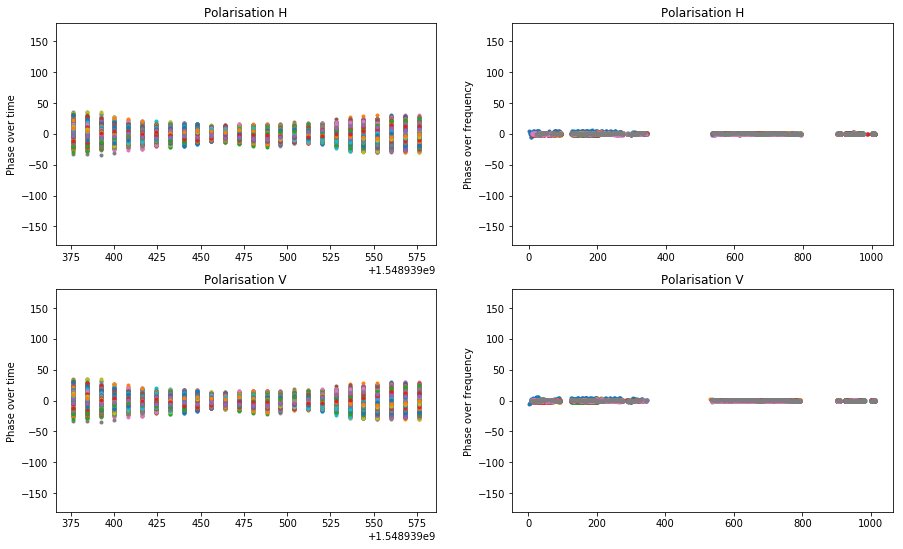

In [12]:
plt.figure(figsize=[15, 9])
for idx, pol in enumerate(['H', 'V']):
    print idx, pol
    
    stime = time.time()    
    data.select(pol=pol, corrprods='cross')
    vis, flags = np.array(katdal.lazy_indexer.DaskLazyIndexer.get([data.vis, data.flags], time_idx)).squeeze()
    visibilities=vis[:]
    dataflags = np.array(flags, dtype=bool)
    visibilities[dataflags]=np.nan    
    phase = np.angle(visibilities, deg=True)
    timephase = np.nanmean(phase, axis=1)
    freqphase = np.mean(phase, axis=0)
    data.select(reset='BF')
    print 'time to calculate phases = {} s'.format(time.time() - stime)
    
    plt.subplot(2, 2, 2*idx+1)
    plt.plot(data.timestamps, timephase, '.')
    plt.ylim([-180, 180])
    plt.ylabel('Phase over time')
    plt.title('Polarisation %s' % pol)
    plt.subplot(2, 2, 2*(idx+1))
    plt.plot(data.channels, freqphase[:,::70], '.')
    plt.ylim([-180, 180])
    plt.ylabel('Phase over frequency')
    plt.title('Polarisation %s' % pol)

0 H


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


time to calculate amp and phase = 0.545837879181 s
1 V
time to calculate amp and phase = 0.278676986694 s


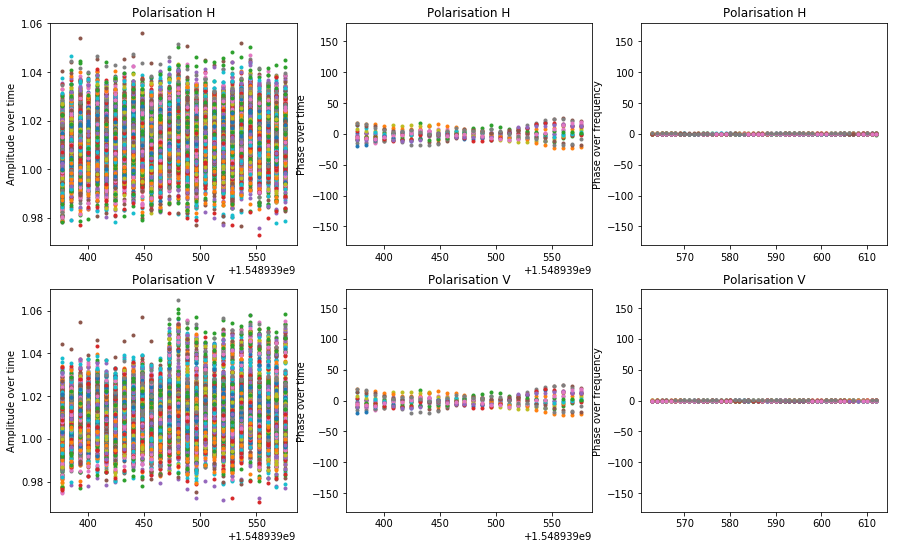

In [13]:
plt.figure(figsize=[15,9])
for idx, pol in enumerate(['H', 'V']):
    print idx, pol
    
    stime = time.time()    
    data.select(pol=pol, corrprods='cross', channels=chan_slice)
    vis, flags = np.array(katdal.lazy_indexer.DaskLazyIndexer.get([data.vis, data.flags], time_idx)).squeeze()
    visibilities=vis[:]
    dataflags = np.array(flags, dtype=bool)
    visibilities[dataflags]=np.nan    
    phase = np.angle(visibilities, deg=True)
    timeseries = np.nanmean(np.abs(visibilities), axis=1)
    timephase = np.nanmean(phase, axis=1)
    freqphase = np.mean(phase, axis=0)
    data.select(reset='BF')
    print 'time to calculate amp and phase = {} s'.format(time.time() - stime)
    
    plt.subplot(2,3,3*idx+1)
    plt.plot(data.timestamps, timeseries, '.')
    plt.ylabel('Amplitude over time')
    plt.title('Polarisation %s' % pol)
    plt.subplot(2,3,3*idx+2)
    plt.plot(data.timestamps, timephase[:,::70], '.')
    plt.ylim([-180, 180])
    plt.ylabel('Phase over time')
    plt.title('Polarisation %s' % pol)
    plt.subplot(2,3,3*(idx+1))
    plt.plot(data.channels[chan_slice], freqphase[:,::70], '.')
    plt.ylim([-180, 180])
    plt.ylabel('Phase over frequency')
    plt.title('Polarisation %s' % pol)